In [92]:
%load_ext autoreload
%autoreload 2

Try to make the plots independent.

## Plot the directions with errorbar + MCMC results + H0 anisotropy

In [93]:
#independent
# Calculate true bulk flow as a function of z
import pandas as pd
import sys
sys.path.append('../tools/')
import clusterfit as cf
from mpl_toolkits.basemap import Basemap

# Lightcone number
i = 1

data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision_outlier_excision.csv')
true_zmaxs, true_ubfs, true_vlons, true_vlats = cf.true_bulk_flow_z(data, zrange0=0.06, zrange1=0.13, zstep=0.02) # ubf_z returns a list
inversed_vlons, inversed_vlats = cf.opposite_direction_arr(true_vlons, true_vlats)

z<0.06, 113 haloes 182.49 km/s (210.96, 7.87)
z<0.08, 184 haloes 145.93 km/s (200.99, -6.12)
z<0.10, 239 haloes 130.20 km/s (208.19, -10.24)
z<0.12, 279 haloes 114.65 km/s (210.22, -7.78)


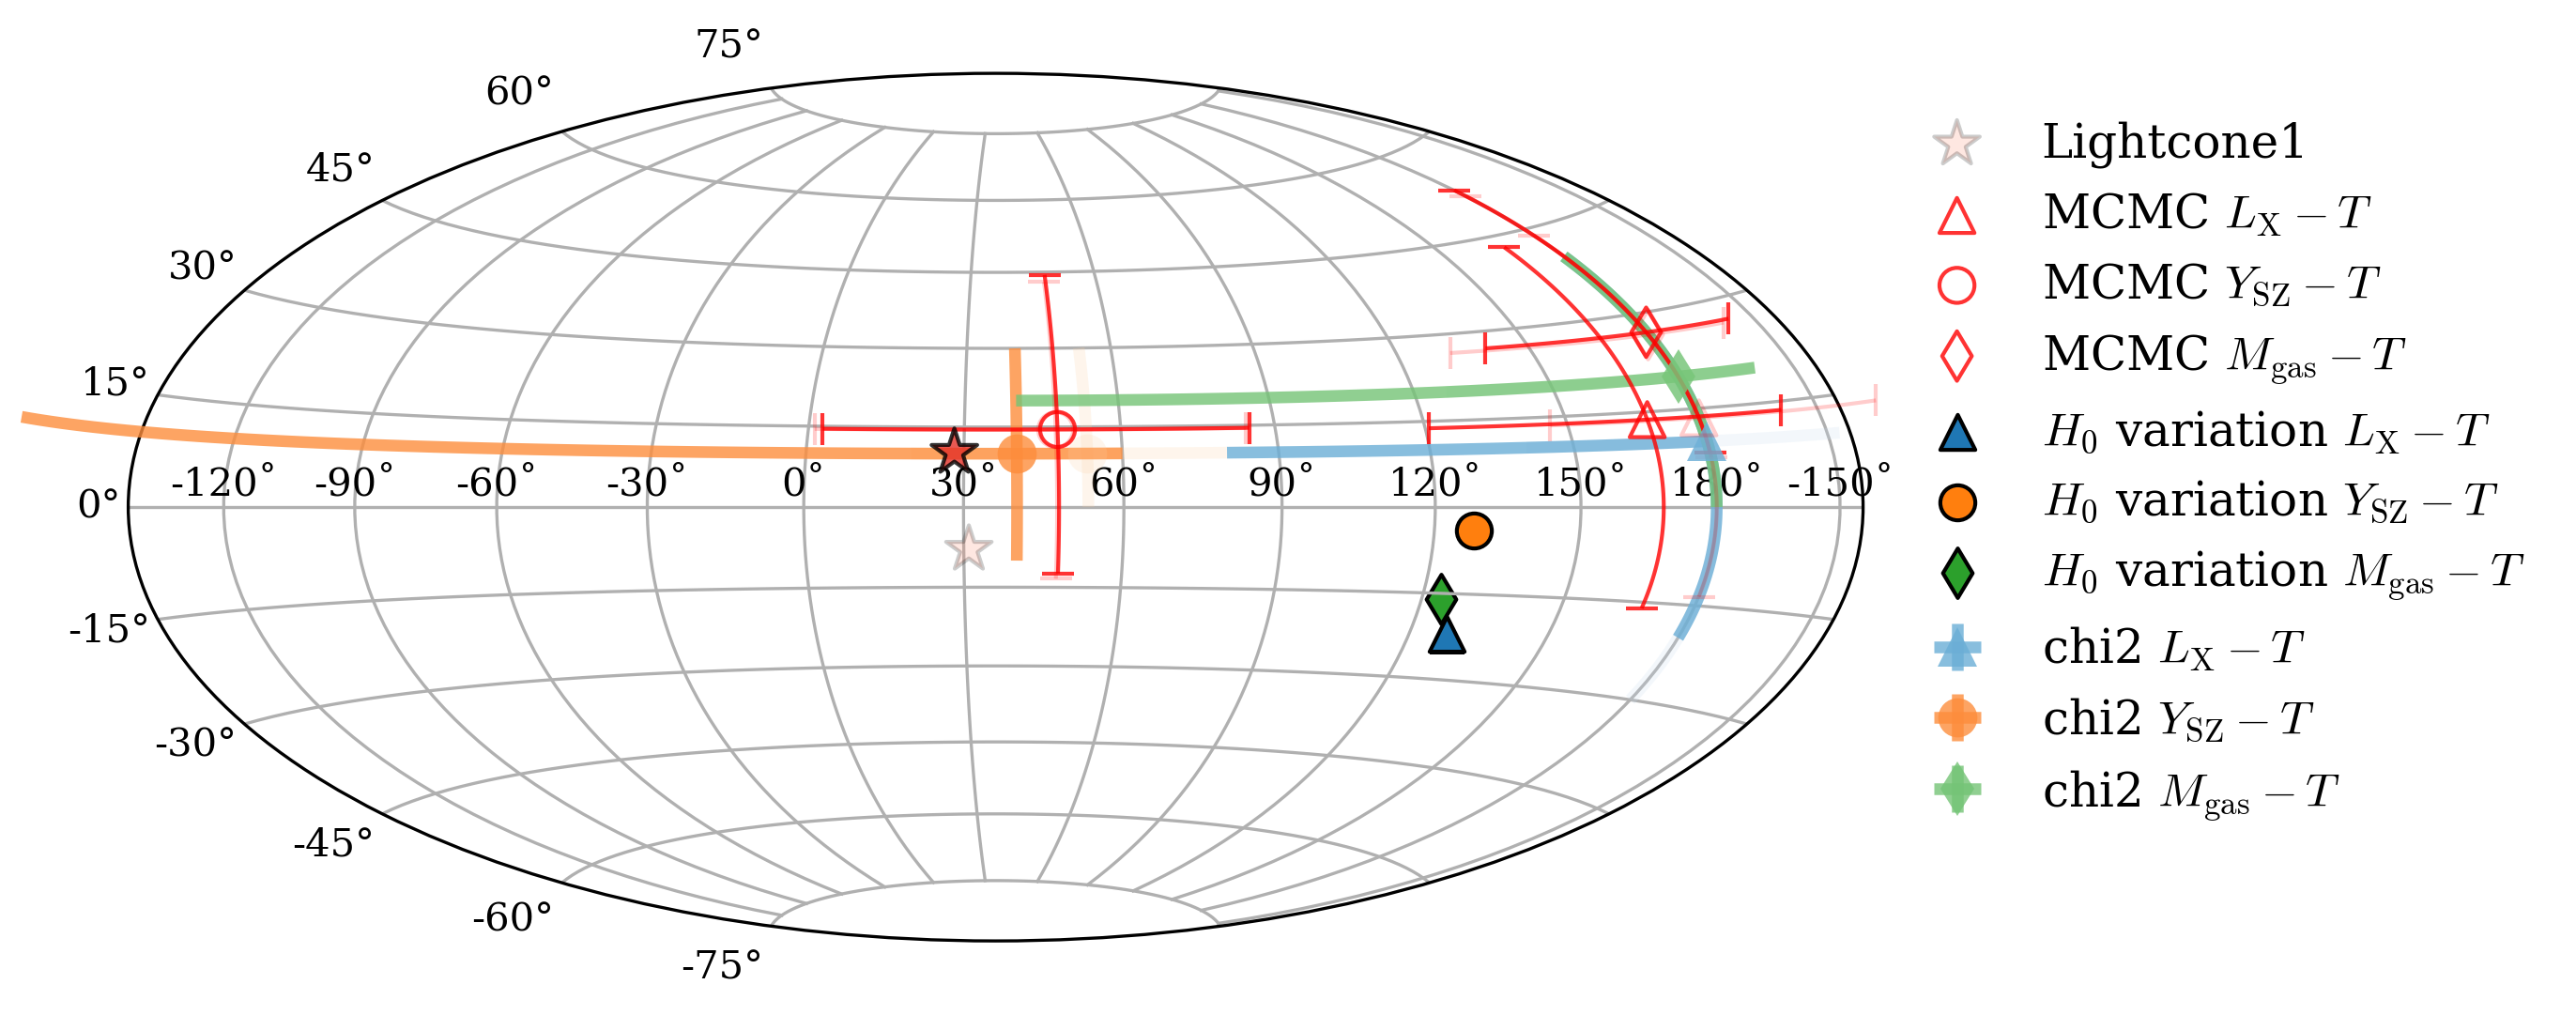

In [96]:
import matplotlib.pyplot as plt
plt.style.use('./nice.mplstyle')
import numpy as np
import pandas as pd 

#Use hammer projection
fig = plt.figure(figsize=(10, 4), dpi=300)
ax = fig.add_subplot(projection='hammer') # WARNING: matplotlib projection takes radian input instead of degree

# Basemap for imshow
# m = Basemap(projection='hammer', lon_0=0)

# Stress only one data to avoid making a messy graph
alphas = [0.2, 0., 0.8, 0.]

# shift to avoid the lon error go outside of the range
if i == 0:
    shift = np.pi*1.4
elif i == 1:
    shift = np.pi*1.8

# Calculate and plot the bulk flow for the first lightcone
ax.scatter(cf.lonshift(inversed_vlons*np.pi/180, shift) , 
           inversed_vlats*np.pi/180, 
           marker='*', c=true_zmaxs, 
           label=f'Lightcone{i}', 
            cmap='Reds', vmin=0, vmax=0.15, 
            s=150, edgecolors='black',
            alpha=alphas, zorder=100
            )

# Plot the modeled bulk flow
markers = ['^','o','d']             # marker palette
colors = plt.cm.tab20c.colors         # color palette
labels = ['chi2 $L_\\mathrm{{X}}-T$', 
          'chi2 $Y_\\mathrm{{SZ}}-T$', 
          'chi2 $M_\\mathrm{{gas}}-T$']

# Plot default method ----------------------------------------------------------
best_fit_file = f'../data/fits/bulk_flow_lightcone{i}.csv'
bootstrap_file = f'../data/fits/bulk_flow_bootstrap_lightcone{i}.csv'
for j, relation in enumerate(['LX-T', 'YSZ-T', 'M-T']):

    # Get best fit parameters
    zmaxs, ubfs, vlons, vlats = cf.read_bulk_flow(best_fit_file, relation=relation, radian=True)

    # Get bootstapping constrain 
    zmaxs, median_ubfs, ubf_lowers, ubf_uppers, peak_vlons, vlon_lowers, vlon_uppers, median_vlats, vlat_lowers, vlat_uppers = cf.read_bulk_flow_bootstrap(
        bootstrap_file=bootstrap_file, best_fit_file=best_fit_file, 
        relation=relation, radian=True, median=True)
    # print(peak_vlons*180/np.pi, median_vlats*180/np.pi)

    ## Shift by a tiny bit to avoid overlap
    shifts = np.linspace(-3,3,len(zmaxs))*np.pi/180
    for n in range(len(zmaxs)):
        # The range of bootstrapping
        if n == 2:
            label_ = labels[j]
        else:
            label_ = None

        # Plot the errorbar range
        ax.errorbar(x=cf.lonshift(peak_vlons[n], shift), 
                    y=median_vlats[n], 
                    yerr=[[vlat_lowers[n]], [vlat_uppers[n]]], 
                    xerr=[[vlon_lowers[n]], [vlon_uppers[n]]], 
                    color=colors[(j+1)*len(zmaxs)-n-1],
                    elinewidth=3, fmt=markers[j], 
                    clip_on=False,         # do turn this on in the final plot
                    alpha=alphas[n], zorder=80,  # sets the overlap behaviour
                    # capthick=3, capsize=4, # errorbar cap
                    label=label_, markersize=10
                    )

        # # The best fits
        # ax.scatter(x=cf.lonshift(vlons[n]+shifts[n], shift), 
        #            y=vlats[n], 
        #            marker=markers[j], label=label_, 
        #            s=80, alpha=alphas[n], zorder=90, edgecolors='black',
        #            color=colors[(j+1)*len(zmaxs)-n-1], clip_on=False)



# Plot MCMC results ----------------------------------------------------------
mcmc_file = f'../data/fits/bulk_flow_mcmc_lightcone{i}.csv'

labels = ['MCMC $L_\\mathrm{{X}}-T$', 
          'MCMC $Y_\\mathrm{{SZ}}-T$', 
          'MCMC $M_\\mathrm{{gas}}-T$']


for j, relation in enumerate(['LX-T', 'YSZ-T', 'M-T']):
    zmaxs, ubfs, ubf_lowers, ubf_uppers, vlons, vlon_lowers, vlon_uppers, vlats, vlat_lowers, vlat_uppers = cf.read_bulk_flow_mcmc(mcmc_file, relation=relation, radian=True)
    
    for n in range(len(zmaxs)):
        # The range of bootstrapping
        if n == 2:
            label_ = labels[j]
        else:
            label_ = None

        # Plot the errorbar range
        ax.errorbar(x=cf.lonshift(vlons[n], shift), 
                    y=vlats[n], 
                    yerr=[[vlat_lowers[n]], [vlat_uppers[n]]], 
                    xerr=[[vlon_lowers[n]], [vlon_uppers[n]]], 
                    color='r',#colors[(j+1)*len(zmaxs)-n-1],
                    elinewidth=1, fmt='', 
                    clip_on=False,         # do turn this on in the final plot
                    alpha=alphas[n], zorder=80,  # sets the overlap behaviour
                    capthick=1, capsize=4, # errorbar cap
                    )

        # The best fits
        ax.scatter(x=cf.lonshift(vlons[n], shift), 
                   y=vlats[n], 
                   marker=markers[j], label=label_, 
                   s=80, alpha=alphas[n], zorder=200, 
                   # color=colors[(j+1)*len(zmaxs)-n-1], 
                   clip_on=False,
                   facecolors='none', edgecolors='r',)





# Plot H0 anisotropies ---------------------------------------------------------
df = pd.read_csv(f'../scripts/H0-dipole-direction-lightcone{i}.csv')

labels = ['$H_0$ variation $L_\\mathrm{{X}}-T$', 
          '$H_0$ variation $Y_\\mathrm{{SZ}}-T$', 
          '$H_0$ variation $M_\\mathrm{{gas}}-T$']

for j, relation in enumerate(['LX-T', 'YSZ-T', 'M-T']):
    mask = (df['relation']==relation)
    lon = df[mask]['lon']
    lat = df[mask]['lat']
    # print(lon, lat)
    ax.scatter(cf.lonshift(lon*np.pi/180, shift),
               lat*np.pi/180, marker=markers[j], label=labels[j], 
               s=80, edgecolors='black')

    



# ax.axis('off')
# ax.set_xticklabels(['']) # disable xticks label

# Shift xticklabels
xticks = np.arange(-150, 181, 30) # label the -180/180 longitude as 180 instead of -180
texts = np.array([f'{x:.0f}˚' for x in xticks]) # do not change order between this line
xticks = cf.lonshift(xticks*np.pi/180, shift, radian=True) # and this line
argsort = np.argsort(xticks) # sort in ascend order
ax.set_xticks(xticks[argsort][:], labels=texts[argsort][:]) # write [1:] to remove the first grid at 0

# Smaller ticks
ax.tick_params(axis='both', which='major', labelsize=10)

# # Nicer legend
# handles, labels = ax.get_legend_handles_labels()
# # Reorder the handles and labels to match the desired layout
# # Assuming you have 7 labels and you want the first one in the first column,
# # and the rest in the second and third columns
# new_order = [1, 4, 2, 5, 3, 6, 0]  # Adjust this order as needed
# handles = [handles[i] for i in new_order]
# labels = [labels[i] for i in new_order]

# # Create the legend with 3 columns
# ax.legend(handles, labels, loc='lower center', shadow=True, ncol=4, bbox_to_anchor=(0.5, -0.3))

ax.legend(loc='upper left', shadow=True, ncol=1, bbox_to_anchor=(1, 1))

# plt.colorbar(label='Redshift Sphere')
plt.grid(True)
plt.savefig(f'/Users/yujiehe/Documents/projects/project-anisotropy/plots/forpaper/result-bulk-flow-direction-lc{i}.pdf', bbox_inches='tight')
plt.show()


## result-ubf-lc0
The default method for amplitudes

In [97]:
import matplotlib.pyplot as plt
plt.style.use('./nice.mplstyle')
import numpy as np
import pandas as pd
import sys
sys.path.append('../tools')
import clusterfit as cf

# Lightcone number
i = 1

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision_outlier_excision.csv')
true_zmaxs, true_ubfs, true_vlons, true_vlats = cf.true_bulk_flow_z(data, method='cluster_average') # ubf_z returns a list
true_zmaxs = np.array(true_zmaxs)

z<0.03, 35 haloes 242.84 km/s (200.62, 21.19)
z<0.04, 51 haloes 197.03 km/s (206.59, 34.59)
z<0.05, 86 haloes 202.36 km/s (211.38, 14.21)
z<0.06, 113 haloes 182.49 km/s (210.96, 7.87)
z<0.07, 151 haloes 167.83 km/s (204.33, 1.15)
z<0.08, 184 haloes 145.93 km/s (200.99, -6.12)
z<0.09, 213 haloes 142.62 km/s (204.93, -9.06)
z<0.10, 239 haloes 130.20 km/s (208.19, -10.24)
z<0.11, 265 haloes 120.61 km/s (209.77, -11.86)
z<0.12, 279 haloes 114.65 km/s (210.22, -7.78)
z<0.13, 291 haloes 113.87 km/s (207.82, -6.01)
z<0.14, 298 haloes 111.79 km/s (210.30, -4.71)
z<0.15, 304 haloes 110.46 km/s (210.23, -1.93)


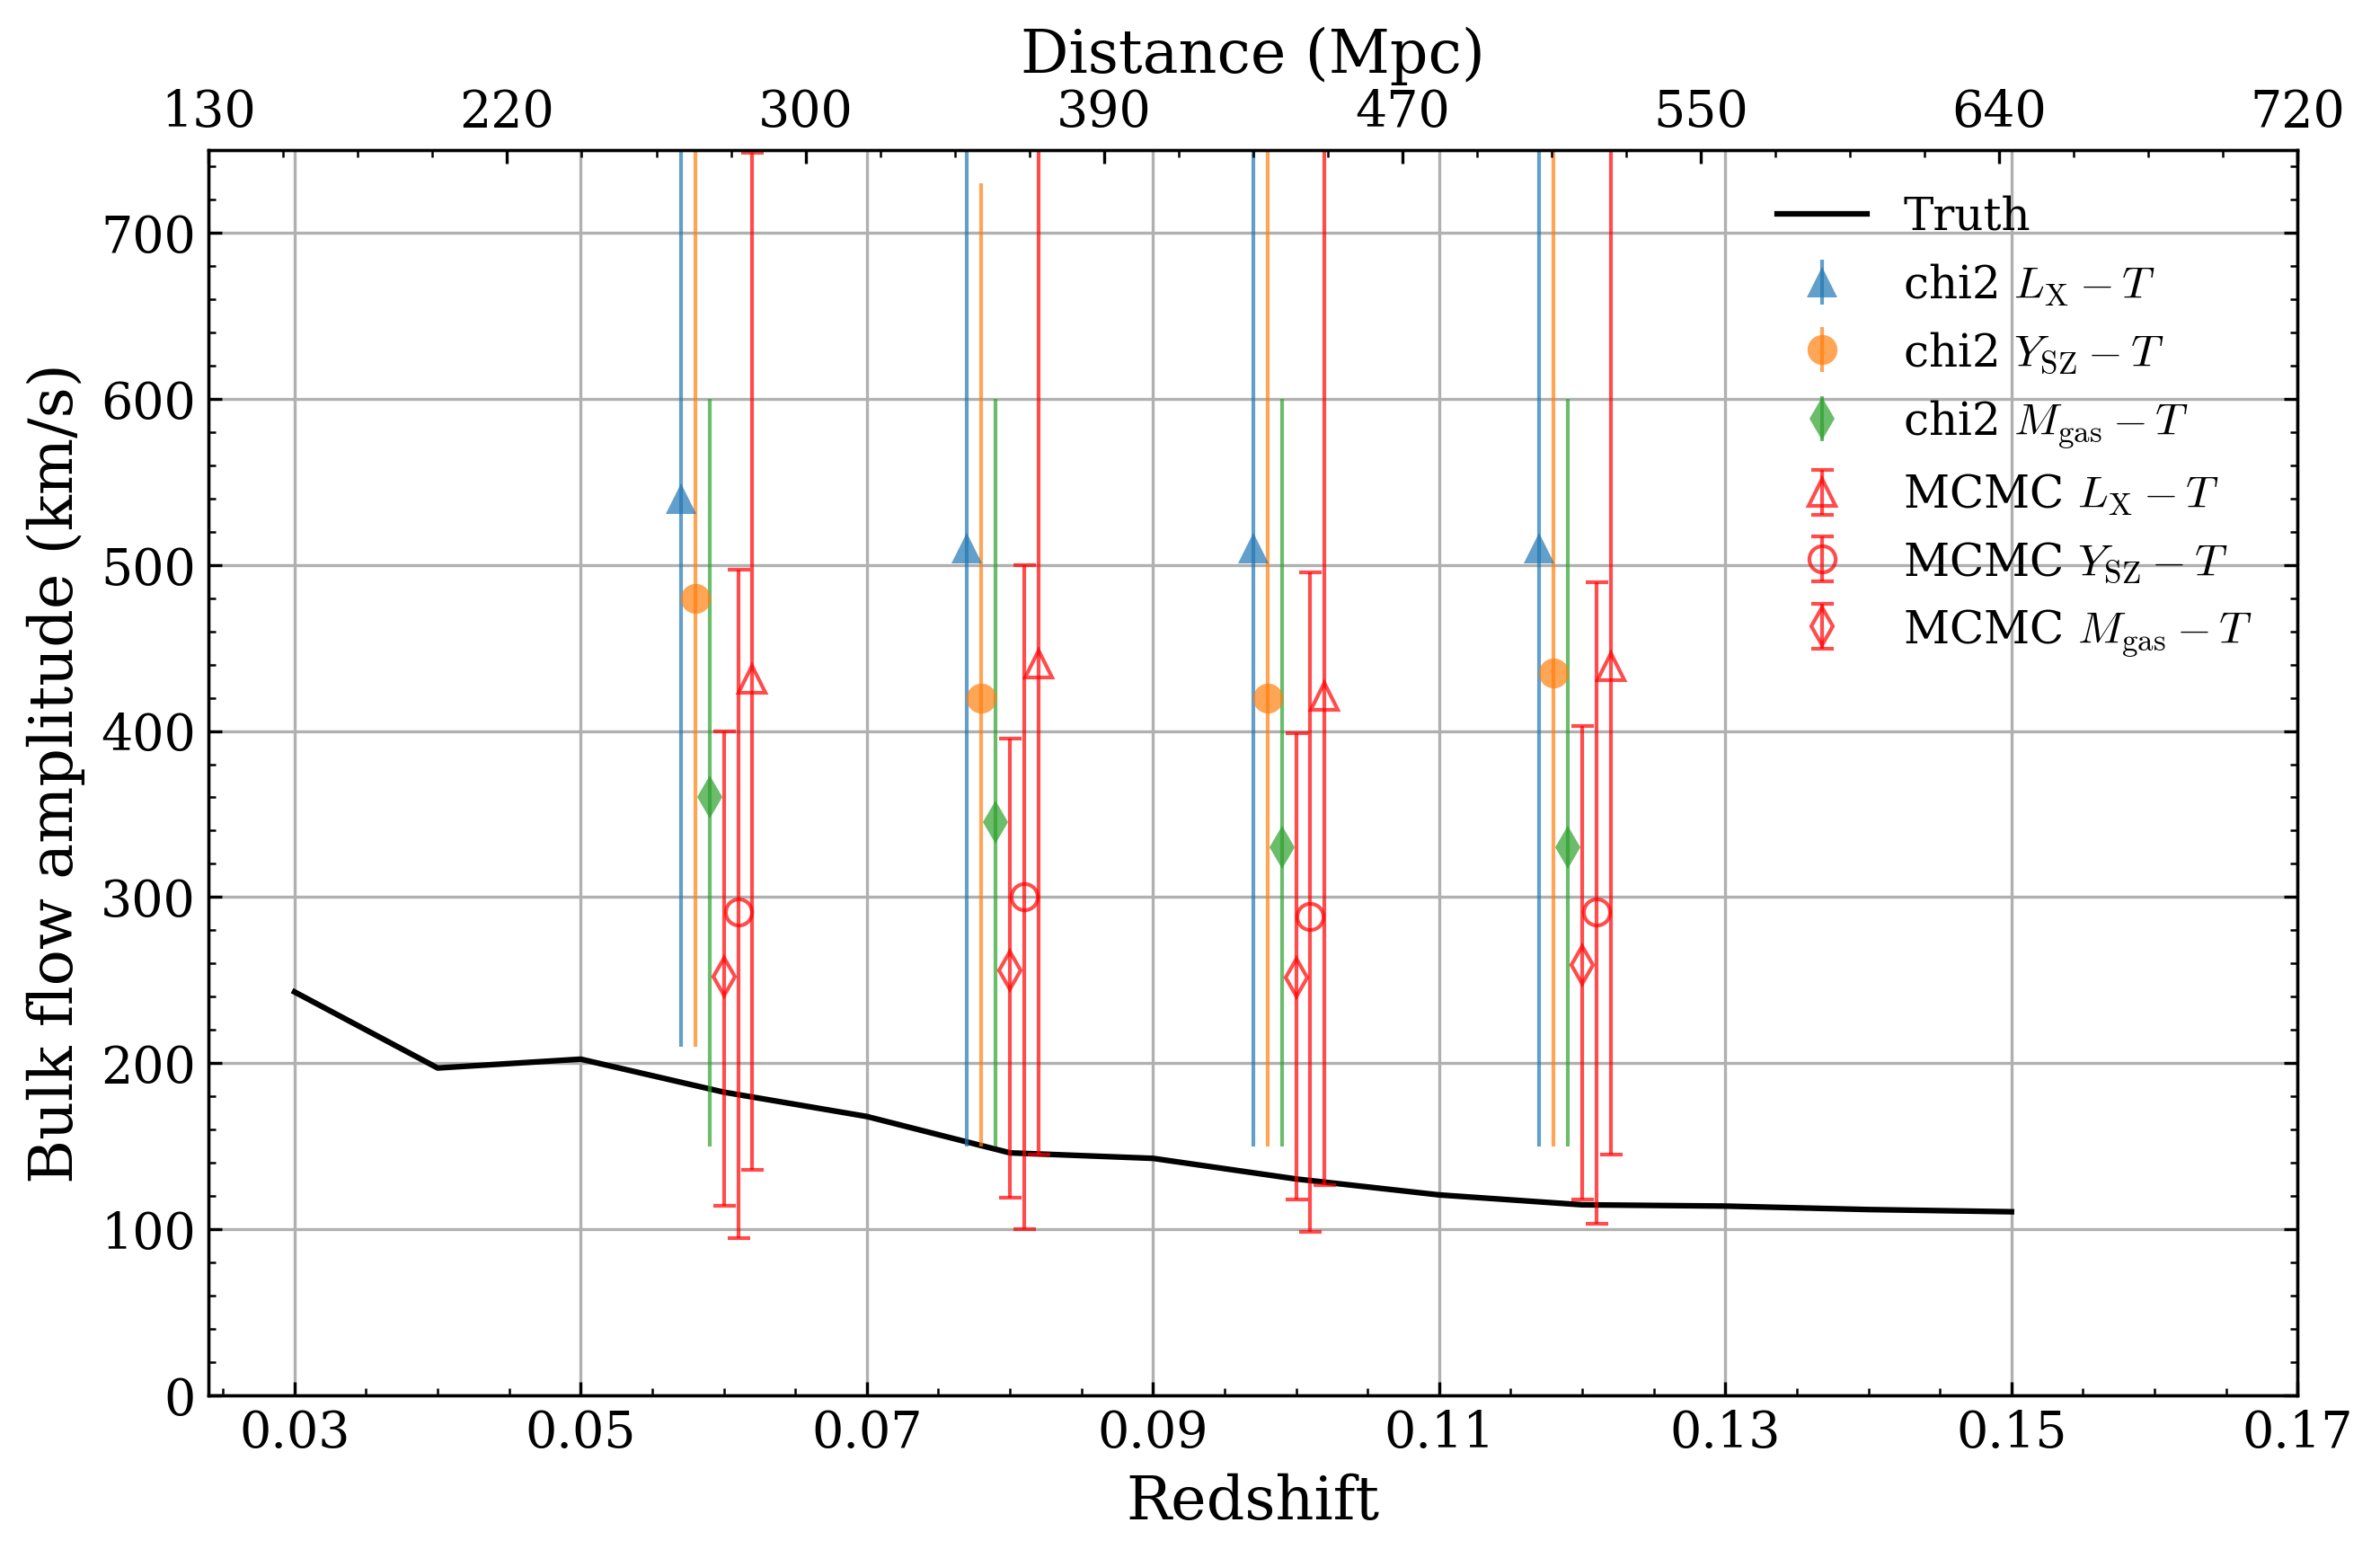

In [98]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

ax.plot(true_zmaxs, true_ubfs, label='Truth', color='black')


# Plot the default method ------------------------------------------------------
best_fit_file = f'../data/fits/bulk_flow_lightcone{i}.csv'
bootstrap_file = f'../data/fits/bulk_flow_bootstrap_lightcone{i}.csv'

markers = ['^', 'o', 'd']
labels = ['chi2 $L_\\mathrm{{X}}-T$', 
          'chi2 $Y_\\mathrm{{SZ}}-T$', 
          'chi2 $M_\\mathrm{{gas}}-T$']

for j, relation in enumerate(['LX-T', 'YSZ-T', 'M-T']):

    # Get best fit parameters
    zmaxs, ubfs, vlons, vlats = cf.read_bulk_flow(best_fit_file, relation=relation, radian=True)

    # Get bootstapping constrain 
    zmaxs, median_ubfs, ubf_lowers, ubf_uppers, peak_vlons, vlon_lowers, vlon_uppers, median_vlats, vlat_lowers, vlat_uppers = cf.read_bulk_flow_bootstrap(
        bootstrap_file=bootstrap_file, best_fit_file=best_fit_file, 
        relation=relation, radian=True, median=True)
    
    # Shift the bars a bit to avoid overlap
    shifts = np.linspace(-0.003, 0.002, 6)
    ax.errorbar(zmaxs+shifts[j], median_ubfs, yerr=[ubf_lowers, ubf_uppers], fmt=markers[j],
                label=labels[j], markersize=8, capsize=3, elinewidth=1, alpha=0.7) #markeredgewidth=1.5)



# Plot the MCMC results --------------------------------------------------------
mcmc_file = f'../data/fits/bulk_flow_mcmc_lightcone{i}.csv'
labels = ['MCMC $L_\\mathrm{{X}}-T$', 
          'MCMC $Y_\\mathrm{{SZ}}-T$', 
          'MCMC $M_\\mathrm{{gas}}-T$']

for j, relation in enumerate(['LX-T', 'YSZ-T', 'M-T']):
    zmaxs, ubfs, ubf_lowers, ubf_uppers, vlons, vlon_lowers, vlon_uppers, vlats, vlat_lowers, vlat_uppers = cf.read_bulk_flow_mcmc(mcmc_file, relation=relation, radian=True)

    # Plot the data
    ax.errorbar(zmaxs+shifts[-j-1], ubfs, yerr=[ubf_lowers, ubf_uppers], fmt=markers[j],
                label=labels[j], markersize=7, markerfacecolor='none', 
                capsize=3, elinewidth=1, markeredgewidth=1, alpha=0.7,
                color='r')





# Set up the plot
ax.set_xlabel('Redshift')
ax.set_ylabel('Bulk flow amplitude (km/s)')

# set a double x label for redshift
zticks = np.arange(0.03, 0.18, 0.02)
ax.set_xticks(zticks)

# set a double x label for redshift
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306) # To convert between redshift and distance
ax2 = ax.twiny()
ax2.set_xlim(np.min(zticks), np.max(zticks))
ax2.set_xticks(zticks)                    # this line maps the x values to the new x axis
Dco = cosmo.comoving_distance(zticks).value # this line sets the tick labels for the new x axis
xtickslabels = np.round(Dco, -1)
xtickslabels = np.array(xtickslabels, dtype=int) 
ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
ax2.set_xlabel('Distance (Mpc)')

ax.grid(True)
#ax.set_xlim(0.03, 0.18)
ax.set_ylim(0, 750)

# legend on the bottom ouside of the plot
ax.legend(loc='upper right', shadow=True)

plt.savefig(f'/Users/yujiehe/Documents/projects/project-anisotropy/plots/forpaper/result-ubf-lc{i}.pdf', bbox_inches='tight')
plt.show()

## MCMC results 

z<0.03, 97 haloes 169.15 km/s (93.34, 50.29)
z<0.04, 172 haloes 157.24 km/s (100.59, 53.93)
z<0.05, 244 haloes 123.68 km/s (99.58, 50.24)
z<0.06, 344 haloes 107.90 km/s (87.62, 44.05)
z<0.07, 391 haloes 100.29 km/s (81.94, 39.14)
z<0.08, 447 haloes 98.06 km/s (85.39, 40.57)
z<0.09, 507 haloes 93.12 km/s (81.62, 37.39)
z<0.10, 544 haloes 90.11 km/s (82.15, 36.71)
z<0.11, 595 haloes 84.77 km/s (76.54, 37.76)
z<0.12, 626 haloes 80.44 km/s (73.60, 34.55)
z<0.13, 653 haloes 75.23 km/s (74.25, 34.01)
z<0.14, 673 haloes 70.64 km/s (70.98, 31.65)
z<0.15, 690 haloes 69.27 km/s (69.27, 31.98)


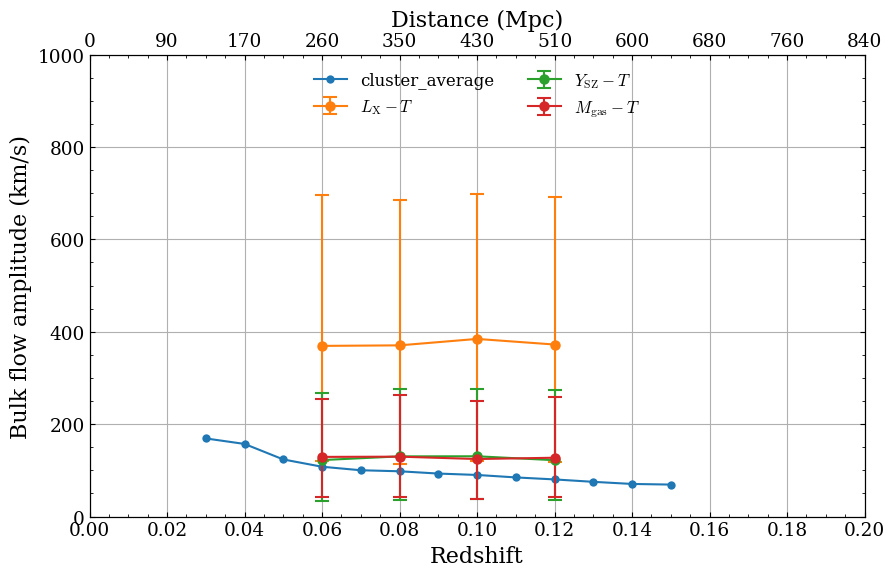

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('nice.mplstyle')
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
import tools.clusterfit as cf
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
fig, ax = plt.subplots(figsize=(10, 6))

# Lightcone number
i = 0

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
for method in ['cluster_average']:
    zmaxs, ubfs, vlons, vlats = cf.true_bulk_flow_z(data, method, n_clusters=len(data)) # ubf_z returns a list
    zmaxs = np.array(zmaxs)

    ax.plot(zmaxs, ubfs, marker='o', label=f'{method}')

# 
df = pd.read_csv(f'../data/fits/bulk_flow_mcmc_lightcone{i}.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    # Select the relation 
    mask = df['scaling_relation']==relation

    # Get the data
    zmaxs = df['zmax'].loc[mask] # Do LX-T for now
    ubfs  = df['ubf'].loc[mask]
    yerr1 = df['ubf_err_lower'].loc[mask]
    yerr2 = df['ubf_err_upper'].loc[mask]
    
    # Type change
    zmaxs = np.array(zmaxs)
    ubfs = np.array(ubfs)
    yerr1 = np.array(yerr1)
    yerr2 = np.array(yerr2)

    # Plot the data
    ax.errorbar(zmaxs, ubfs, yerr=[yerr1, yerr2], marker='o', label=f'{label}', capsize=5, elinewidth=1.5, markeredgewidth=1.5)

# Set up the plot
ax.set_xlabel('Redshift')
ax.set_ylabel('Bulk flow amplitude (km/s)')
ax.set_xticks(np.linspace(0, 0.2, 11))

# set a double x label for redshift
ax2 = ax.twiny()
ax2.set_xlim(0, 0.2)
ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis

# Calculate comoving distance
Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
xtickslabels = np.round(Dco, -1)
xtickslabels = np.array(xtickslabels, dtype=int) 
ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
ax2.set_xlabel('Distance (Mpc)')

ax.grid(True)
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)

# legend on the bottom ouside of the plot
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.show()

z<0.03, 111 haloes 214.33 km/s (210.80, 22.04)
z<0.04, 148 haloes 196.88 km/s (211.04, 25.61)
z<0.05, 227 haloes 176.87 km/s (208.86, 14.57)
z<0.06, 305 haloes 156.10 km/s (205.55, 6.11)
z<0.07, 383 haloes 139.95 km/s (203.90, 0.16)
z<0.08, 458 haloes 123.48 km/s (195.97, -6.28)
z<0.09, 516 haloes 117.41 km/s (195.79, -9.59)
z<0.10, 567 haloes 107.97 km/s (199.21, -10.40)
z<0.11, 619 haloes 103.65 km/s (201.86, -11.14)
z<0.12, 646 haloes 100.74 km/s (202.78, -10.35)
z<0.13, 680 haloes 96.91 km/s (203.87, -8.67)
z<0.14, 700 haloes 96.96 km/s (204.85, -7.04)
z<0.15, 711 haloes 94.92 km/s (204.43, -5.57)


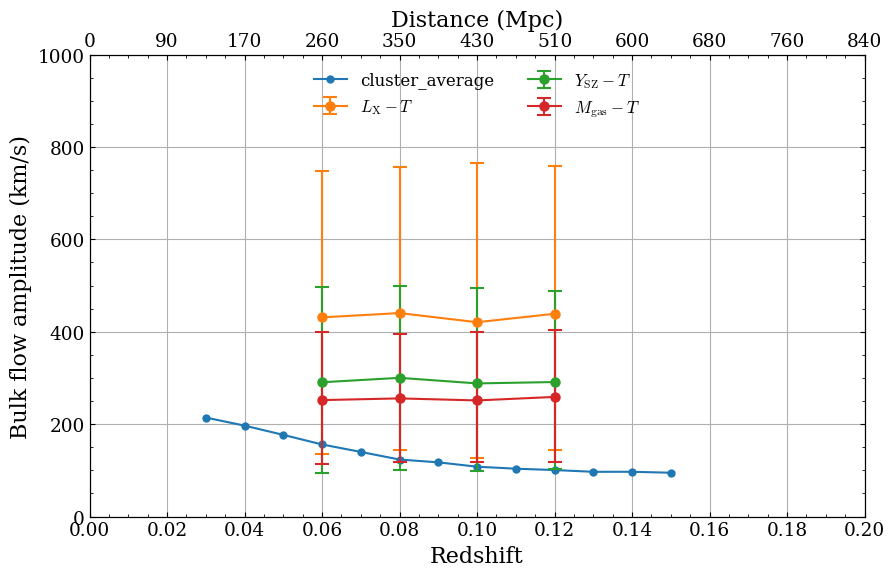

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('nice.mplstyle')
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
import tools.clusterfit as cf
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
fig, ax = plt.subplots(figsize=(10, 6))

# Lightcone number
i = 1

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv(f'../data/samples_in_lightcone{i}_with_trees_duplicate_excision.csv')
for method in ['cluster_average']:
    zmaxs, ubfs, vlons, vlats = cf.true_bulk_flow_z(data, method, n_clusters=len(data)) # ubf_z returns a list
    zmaxs = np.array(zmaxs)

    ax.plot(zmaxs, ubfs, marker='o', label=f'{method}')

# 
df = pd.read_csv(f'../data/fits/bulk_flow_mcmc_lightcone{i}.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    # Select the relation 
    mask = df['scaling_relation']==relation

    # Get the data
    zmaxs = df['zmax'].loc[mask] # Do LX-T for now
    ubfs  = df['ubf'].loc[mask]
    yerr1 = df['ubf_err_lower'].loc[mask]
    yerr2 = df['ubf_err_upper'].loc[mask]
    
    # Type change
    zmaxs = np.array(zmaxs)
    ubfs = np.array(ubfs)
    yerr1 = np.array(yerr1)
    yerr2 = np.array(yerr2)

    # Plot the data
    ax.errorbar(zmaxs, ubfs, yerr=[yerr1, yerr2], marker='o', label=f'{label}', capsize=5, elinewidth=1.5, markeredgewidth=1.5)

# Set up the plot
ax.set_xlabel('Redshift')
ax.set_ylabel('Bulk flow amplitude (km/s)')
ax.set_xticks(np.linspace(0, 0.2, 11))

# set a double x label for redshift
ax2 = ax.twiny()
ax2.set_xlim(0, 0.2)
ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis

# Calculate comoving distance
Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
xtickslabels = np.round(Dco, -1)
xtickslabels = np.array(xtickslabels, dtype=int) 
ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
ax2.set_xlabel('Distance (Mpc)')

ax.grid(True)
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 1000)

# legend on the bottom ouside of the plot
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.show()